In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)

for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

import sys
sys.version


C:\Users\Chanv\anaconda3\envs\tf2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Num GPUs Available:  1
True
2.10.1


'3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC v.1929 64 bit (AMD64)]'

In [2]:
DATASET_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train'
SINGLE_TEST_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test002'
BATCH_SIZE = 8
EPOCHS = 3
MODEL2_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/lstm_model2.hdf5"

In [3]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [4]:
def evaluate(size, sequences, reconstructed_sequences):
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,size)])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    mse = np.mean(np.square(sequences - reconstructed_sequences), axis=(1,2,3))

    # plot the regularity scores
    plt.plot(sr)
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.show()

    return mse

In [5]:
def plot_mse_change(mse_values):

    # Create frame numbers starting from 1 to the length of MSE values
    frame_numbers = [x*10 for x in range(len(mse_values))]

    # Plot MSE against frame number
    plt.plot(frame_numbers, mse_values, marker='o', linestyle='-')
    plt.xlabel('Frame Number')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Against Frame Number')
    plt.grid(True)
    plt.show()

In [6]:
import cv2
import os
import numpy as np

def preprocess_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []

    
    # Loop through each video sequence in the dataset
    for sequence_folder in os.listdir(data_path):
        sequence_path = os.path.join(data_path, sequence_folder)
        if sequence_path.endswith("Store"):
            continue
        print(sequence_path)
        
        frames = []
        # Read frames from the video sequence
        for frame_file in sorted(os.listdir(sequence_path)):
            if frame_file.endswith("Store"):
                continue
            
            if len(frames) == 10:
                preprocessed_data.append(frames)
                frames = []
           
            frame_path = os.path.join(sequence_path, frame_file)
            frame = cv2.imread(frame_path)
            frame = cv2.resize(frame, output_shape)  # Resize frame
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
            frames.append(frame)
        preprocessed_data.append(frames)

    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data


# Path to the Ped2 dataset
data_path = DATASET_PATH

# Preprocess the Ped2 dataset
preprocessed_data = preprocess_dataset(data_path)
preprocessed_data = preprocessed_data[:150]

# Check the shape of the preprocessed data
print("Preprocessed dataset shape:", preprocessed_data.shape)


C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train001
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train002
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train003
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train004
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train005
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train006
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train007
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train008
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train009
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train010
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train011
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train012
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train013
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train014
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train015
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Train\Train016
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSD

In [7]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

def get_model2():

    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(64, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 10, 128, 128, 3)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    # # # # #
    seq.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(64, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(3, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())

    return seq

In [8]:
seq2 = get_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 32, 32, 64)   23296     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 32, 32, 64)   128       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 16, 16, 32)   51232     
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 16, 16, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 16, 16, 64)    2

In [9]:
from sklearn.model_selection import train_test_split

# Build autoencoder model
train_data, val_data = train_test_split(preprocessed_data, test_size=0.2, random_state=42)




In [11]:
# Train autoencoder
seq2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6))
seq2.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=BATCH_SIZE)
seq2.save(MODEL2_PATH)



Epoch 1/20
15/15 [==============================] - 29s 849ms/step - loss: 6.0030 - val_loss: 4.0543
Epoch 2/20
15/15 [==============================] - 8s 528ms/step - loss: 3.7461 - val_loss: 3.7153
Epoch 3/20
15/15 [==============================] - 8s 563ms/step - loss: 3.6909 - val_loss: 3.7140
Epoch 4/20
15/15 [==============================] - 8s 564ms/step - loss: 3.6903 - val_loss: 3.7138
Epoch 5/20
15/15 [==============================] - 9s 583ms/step - loss: 3.6902 - val_loss: 3.7137
Epoch 6/20
15/15 [==============================] - 9s 601ms/step - loss: 3.6901 - val_loss: 3.7137
Epoch 7/20
15/15 [==============================] - 9s 593ms/step - loss: 3.6901 - val_loss: 3.7136
Epoch 8/20
15/15 [==============================] - 9s 588ms/step - loss: 3.6901 - val_loss: 3.7136
Epoch 9/20
15/15 [==============================] - 9s 586ms/step - loss: 3.6901 - val_loss: 3.7136
Epoch 10/20
15/15 [==============================] - 9s 587ms/step - loss: 3.6900 - val_loss: 3.713

# Testing

In [12]:
test_path = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped1/Test/Test001'

In [13]:
def preprocess_test_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []
        
    # Read frames from the video sequence
    frames = []
    for frame_file in sorted(os.listdir(data_path)):
        
        if frame_file.endswith("Store"):
                continue
        
        if len(frames) == 10:
            preprocessed_data.append(frames)
            frames = []
        
        frame_path = os.path.join(data_path, frame_file)
        
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, output_shape)  # Resize frame
        frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
        
        frames.append(frame)
        
    preprocessed_data.append(frames)


    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data

test_data = preprocess_test_dataset(test_path)
print("Preprocessed dataset shape:", preprocessed_data.shape)

Preprocessed dataset shape: (150, 10, 128, 128, 3)


In [14]:
predicted_sequences = seq2.predict(test_data)

1/1 [==============================] - 11s 11s/step


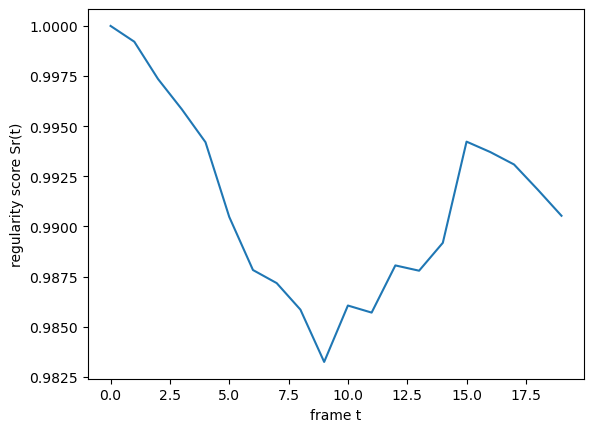

In [15]:
mse2 = evaluate(20, test_data, predicted_sequences)

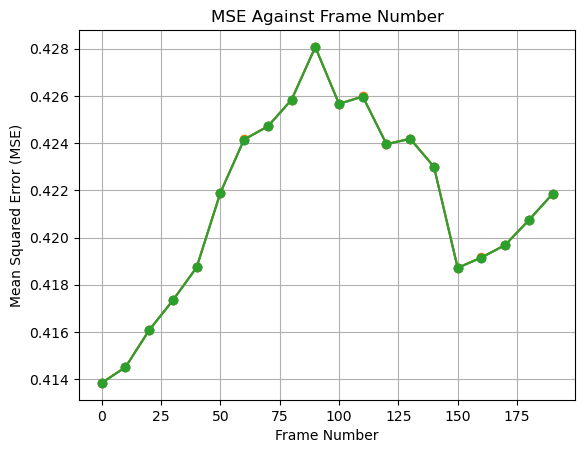

In [16]:
plot_mse_change(mse2)

In [17]:
print(mse2)

[[0.41384083 0.41384572 0.41384092]
 [0.41450596 0.41451174 0.4145051 ]
 [0.41607624 0.41608    0.41607457]
 [0.4173425  0.4173481  0.4173413 ]
 [0.4187367  0.41874155 0.41873676]
 [0.42189512 0.42189986 0.42189485]
 [0.42415562 0.42415944 0.42415452]
 [0.42471394 0.424719   0.42471275]
 [0.42583767 0.42584333 0.4258364 ]
 [0.42807412 0.42807907 0.42807236]
 [0.4256661  0.4256722  0.42566505]
 [0.42597637 0.42598176 0.42597565]
 [0.42395884 0.4239644  0.42395777]
 [0.42418498 0.42418948 0.4241851 ]
 [0.4229993  0.42300472 0.42299834]
 [0.4187159  0.41872048 0.4187153 ]
 [0.41915402 0.41915917 0.41915387]
 [0.4196824  0.4196868  0.4196825 ]
 [0.42074043 0.42074585 0.42074051]
 [0.42185122 0.42185512 0.42184964]]
